# Szegedy’s quantum walk with queries (Santos, 2016)

Implementation of the algorithm described in [this paper](https://link.springer.com/article/10.1007/s11128-016-1427-4).

## Import libraries

In [592]:
import pennylane as qml
import pennylane.numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [593]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3, suppress=True)
qml.__version__

'0.41.1'

## 2 Szegedy's Quatum Walk

In [594]:
N = 40 # dimension of the graph
n = int(np.ceil(np.log2(N))) # dimension of the associated Hilbert space
print(f"N = {N}")
print(f"n = {n}")

N = 40
n = 6


### Stochastic matrices

![Complete graph with m=5, n=1](complete_graph_m1.PNG "Complete graph with m=5, n=1")

#### $P'$

In [595]:
m = 5 # marked state
absorbing = True # absorbing QRW for marked states
# transition matrix
P = block_diag(1/(N-1) * (np.ones(N) - np.eye(N)), np.eye(2**n-N))
# absorbing RW
if (absorbing):
    for i in range(N):
        P[m-1, i] = 0
    P[m-1, m-1] = 1

# print(P)
print(P.shape)
# print(P*P.T)

(64, 64)


#### $R_A$

In [596]:
# initial state of the quantum walk
RA = np.zeros((2**(2*n), 2**(2*n)))

for x in range(2**n):
    phi = np.zeros((2**(2*n), 1))
    ket_x = np.zeros((2**n, 1))
    ket_x[x] = 1
    for y in range(2**n):
        ket_y = np.zeros((2**n, 1))
        ket_y[y] = np.sqrt(P[x][y])
        phi += np.kron(ket_x, ket_y) # x⊗y
    # print(f"x={x}")
    # print(np.sum(phi**2)) # norm-square: should be one for a "valid" quantum state
    # print(phi.T)   
    RA += np.dot(phi, phi.T)    
RA = 2 * RA - np.eye(2**(2*n))
print(RA.shape)
# print(RA)
# print('\n')
# print(np.dot(RA, RA.T))
print(r'Is $R_A$ unitary (left)?', np.all(np.allclose(np.dot(RA, RA.T), np.eye(2**(2*n)))))
# print(np.dot(RA.T, RA))
print(r'Is $R_A$ unitary (right)?', np.all(np.allclose(np.dot(RA.T, RA), np.eye(2**(2*n)))))

(4096, 4096)
Is $R_A$ unitary (left)? True
Is $R_A$ unitary (right)? True


#### $R_B$

In [597]:
RB = np.zeros((2**(2*n), 2**(2*n)))

for y in range(2**n):
    psi = np.zeros((2**(2*n), 1))
    ket_y = np.zeros((2**n, 1))
    ket_y[y] = 1
    for x in range(2**n):
        ket_x = np.zeros((2**n, 1))
        ket_x[x] = np.sqrt(P[y][x])
        psi += np.kron(ket_x, ket_y) # y⊗x
    RB += np.dot(psi, psi.T)    
RB = 2 * RB - np.eye(2**(2*n))
print(RB.shape)
# print(RB)
# print(np.dot(RB, RB.T))
print('Is RB unitary (left)?', np.all(np.allclose(np.dot(RB, RB.T), np.eye(2**(2*n)))))
print('Is RB unitary (right)?', np.all(np.allclose(np.dot(RB.T, RB), np.eye(2**(2*n)))))

(4096, 4096)
Is RB unitary (left)? True
Is RB unitary (right)? True


### Searching

In [598]:
# initial state
psi = np.zeros((2**(2*n)))
for x in range(N):
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        ket_y = np.zeros((2**n))
        ket_y[y] += np.sqrt(P[x][y])
        psi += np.kron(ket_x, ket_y)    
psi /= np.sqrt(N)
# print(psi)
print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(psi**2)), 1))

Is the statevector valid? True


In [637]:
# initial state
phi = np.zeros((2**(2*n)))
for x in range(N):
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        if y==x:
            continue
        ket_y = np.zeros((2**n))
        ket_y[y] += 1/np.sqrt(N-1)
        phi += np.kron(ket_x, ket_y)    
phi /= np.sqrt(N)
# print(phi)
print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(phi**2)), 1))

Is the statevector valid? True


In [599]:
Up = np.dot(RB, RA) # marked walk operator
np.allclose(Up, Up.T) 

False

### Quantum circuit

In [645]:
num_qubits = 2*n
# Create a device for simulation
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(steps):
    qml.StatePrep(phi, wires=range(num_qubits))
    # [qml.Hadamard(i) for i in range(num_qubits)]
    for _ in range(steps):
        # Apply the unitary matrix
        qml.QubitUnitary(Up, wires=range(num_qubits), id=r"$U_p$")
    # Measure all qubits
    return qml.state()

(<Figure size 700x1300 with 1 Axes>, <Axes: >)

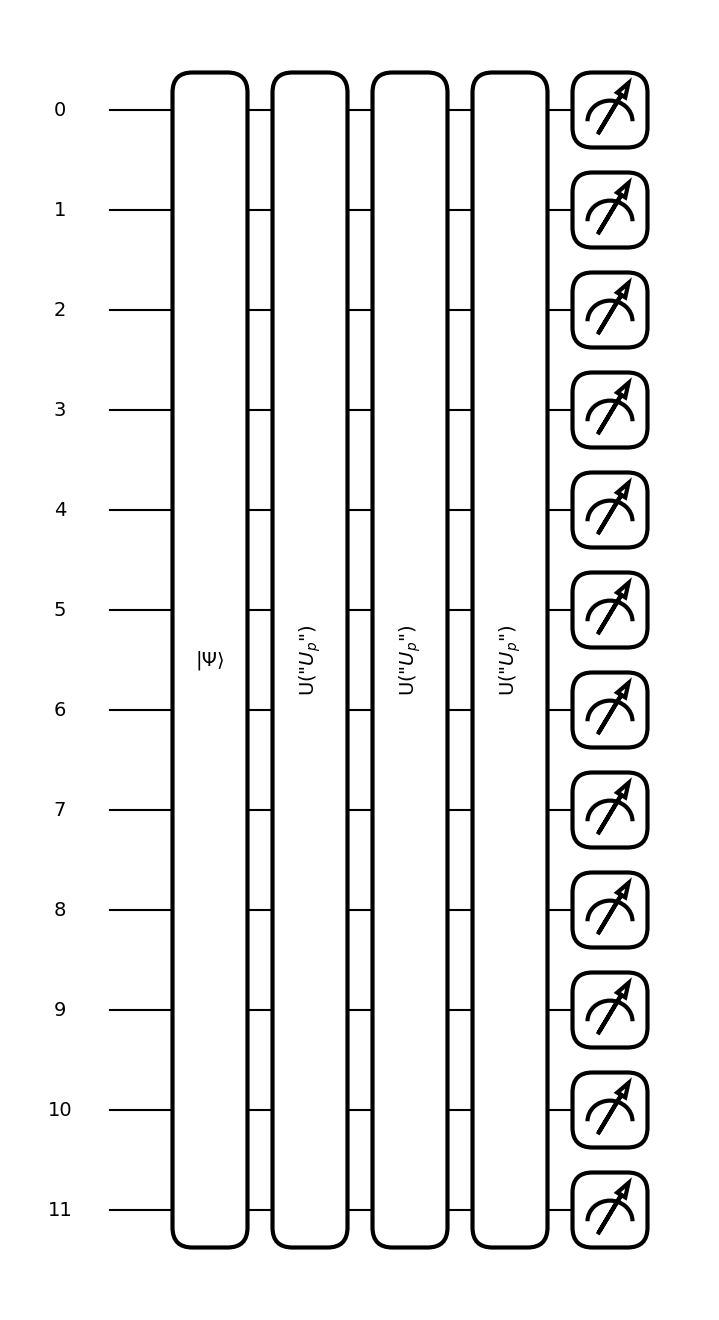

In [646]:
# draw a sample quantum circuit
qml.draw_mpl(circuit)(3)

In [658]:
# data arrays
m_data = []

# Execute the circuit
print("Steps\tsum_pm")
print("---------------")
steps = int(np.ceil(2*np.pi*N**0.5))
for k in range(steps+1):
    state_vector = np.abs(circuit(k)**2)
    sum_pm = np.sum(state_vector[(m-1)*2**n:(m)*2**n])
    # sum_pm = 0
    # for i in range(N):
    #     if i==m-1:
    #         continue
    #     sum_pm += state_vector[2**n*i+(m-1)] 
    m_data.append(sum_pm) 
    max_index = qml.math.argmax(state_vector)
    print(f"{k}\t{sum_pm:.3f}")

Steps	sum_pm
---------------
0	0.025
1	0.210
2	0.464
3	0.612
4	0.548
5	0.319
6	0.084
7	0.001
8	0.104
9	0.289
10	0.394
11	0.331
12	0.152
13	0.012
14	0.043
15	0.250
16	0.498
17	0.616
18	0.520
19	0.278
20	0.058
21	0.006
22	0.132
23	0.315
24	0.396
25	0.307
26	0.123
27	0.004
28	0.066
29	0.290
30	0.529
31	0.616
32	0.488
33	0.237
34	0.037
35	0.016
36	0.161
37	0.338
38	0.393
39	0.281
40	0.096


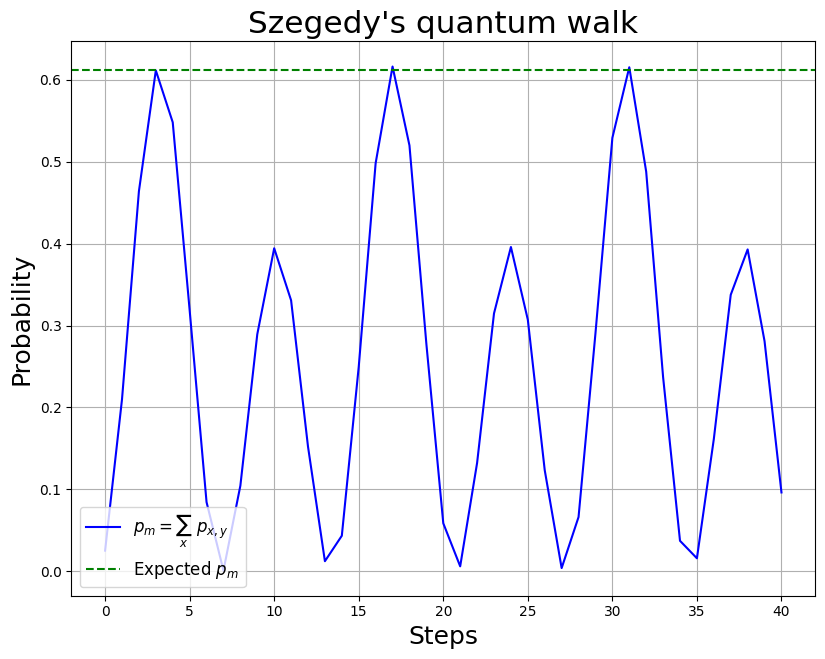

In [659]:
scale_factor = 1.5
default_figsize = plt.rcParams["figure.figsize"]
scaled_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

plt.figure(figsize=scaled_figsize)
plt.plot(range(steps+1), m_data, "b-", label=r"$p_m = \sum_x~p_{x,y}$")
plt.axhline(y = 0.5 + 1/np.sqrt(2*N), color="green", linestyle="--", label=r"Expected $p_m$")
plt.legend(fontsize=12, loc="lower left")
plt.title("Szegedy's quantum walk", fontsize=15*scale_factor)
plt.xlabel("Steps", fontsize=12*scale_factor)
plt.ylabel("Probability", fontsize=12*scale_factor)
# plt.ylim((0, 1))
plt.grid()
plt.show()

In [652]:
print(f"m     = {np.argmax(m_data)}\np(m)  = {np.max(m_data)}")
print(f"p'(m) = {0.5 + 1/np.sqrt(2*N)}")

m     = 16
p(m)  = 0.6163788958750431
p'(m) = 0.6118033988749895


## Szegedy's quantum walk with queries